# Analysis of the Saphire Iris Rotation Run

Before you go on with your analysis maybe download the 014 Andor scan and run this file to see if it works properly. Then duplicate that file and copy the cells you want to recreate

In [13]:
## necessary import statements
from HARP.scan_anal import Scan
from HARP.iris_functions import Iris
from HARP.image_processing import Image
import os
from scipy.optimize import curve_fit
import numpy as np 
import matplotlib.pyplot as plt
from functions import Andor_calib
from functions import Adams_wedge_thickness
import warnings
import matplotlib.colors as colors
warnings.filterwarnings('ignore')

## Setup your scan

In [14]:
# Define your iris calibration that was used on that day (check if the hour is correct)
power = np.array([190, 190,170,170,170,170,160,160,110,80,65,23,2,0])*1e-3 #list is in mW as that is what we wrote down but the multiplication is to change it to W
iris_pos= np.array([45,40,35,30,25,20,15,10,0,-10,-20,-30,-40,-45]) #make sure you have same number of iris positions and powers
iris = Iris()
iris.specify_calib(iris_positions=iris_pos, powers=power)
iris.specify_params(w0_init=100e-6, f=0.75, wl=1800e-9, M2=1, reprate=1000,pulse_duration=15e-15) #specify your params!

In [15]:
#specify where the folder in which the files are:
data_folder = os.path.join('/Volumes/qolslc/20120009 - Matthews' , 'AndorScan-014-20220201-1718 - rotation_scan_irisfirst') #first argument where you store your data and second is specific folder
h5files = [i for i in os.listdir(data_folder) if i != 'Camera.h5'] # I am only taking one of the cycles for now
h5files

['ImgData-002-20220201-173456.h5',
 'ImgData-003-20220201-174256.h5',
 'ImgData-004-20220201-175057.h5',
 'ImgData-000-20220201-171855.h5',
 'ImgData-001-20220201-172655.h5']

In [16]:
#Open the Scan class
saph = Scan()
saph.set_folder(data_folder)
# fill out which are available from 
saph.set_params(iris=None, wedge=1060, rotation=None, MCPPos=90000) # here fill out the variables that you are not scanning through. This scan is Rotation and iris so I fill out the other MCPPos and Wedge
saph.set_verlim(70, 180) #this is the vertical cropping you want to do
saph.set_eVlim((7,25)) #this is the energy limits you want to look at

In [17]:
# #Add pictures to the scan

# #To add individual file uncomment the following:
saph.populate_scan_h5(h5files[0], function=Andor_calib)

# #To add all files or at least multiples uncomment:
#for f in h5files:
#    try:
#        saph.populate_scan_h5(f, function=Andor_calib)
#    except:
#        print('Failed to add {}'.format(f))

100%|██████████| 44/44 [00:00<00:00, 59.08it/s]


## Background

Sometimes file fail to add so we need the try expect to avoid it. Good practise is to go and investigate why - the 003 file in Saph was for example 0 bites so I assume the file got corrupted. Also might be easier to do main analysis on only one cycle first and only then add more files and rerun the code - for example it is possible something change in the lab or something.


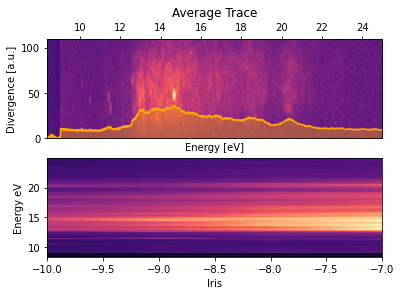

In [18]:
# I use this to plot quickly the average to so I can see how to crop and eV limits - when you know what you want just rerun, staritng from Scan() cell, with new limits
fig, ax = plt.subplots(2)
im, ax[0], ax2 = saph.plot_average(ax[0])
ax[0].set_title('Average Trace')
ax[0].xaxis.tick_top()
ax[0].set_xlabel('Energy [eV]', va = 'top')
ax[0].set_ylabel('Divergence [a.u.]')
im, ax[1] = saph.plot_scan_mean(ax[1], 'iris')
ax[1].set_xlabel('Iris')
ax[1].set_ylabel('Energy eV')
plt.show()

### Dealing with background
So dealing with background is not trivial and I have to work on it a bit more. 
For same background on all plots you can use 3 different ways. 
a) add_background_from_scan(self, closed_iris_position = -45)

This points to the position od fully closed iris and sets it as the background array for all your pictures

b) add_background(self, bg_array)

Here you can upload another numpy array e.g. if you saved a file before you started scan

c) Do nothing and expect it to find itself

if you use a or b just then run 
scan.substract_bg() 

if you chose c) 
you need to specify which part of the scan you want to take as mean - e.g. if you want to take the 0,10 corner and a square of 10 by 20 run: 
scan.substract_bg(byitself=True, bg_lim = [0,10,10,20])

*Other things to add is getting rid of those tiny dots*

*Also work on scatter?*


In [19]:
#adding background by itself:

saph.substract_bg(byitself=True, bg_lim=[0,0,10,10])

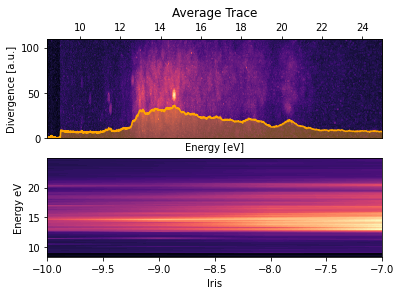

In [20]:
#see how background subtraction worked on average
fig, ax = plt.subplots(2)
im, ax[0], ax2 = saph.plot_average(ax[0])
ax[0].set_title('Average Trace')
ax[0].xaxis.tick_top()
ax[0].set_xlabel('Energy [eV]', va = 'top')
ax[0].set_ylabel('Divergence [a.u.]')
im, ax[1] = saph.plot_scan_mean(ax[1], 'iris')
ax[1].set_xlabel('Iris')
ax[1].set_ylabel('Energy eV')
plt.show()

In [21]:
# Adding the different column variables if you want.

# Adding intensity variable based on iris position 
saph.add_calibration_stage('intensity', iris.get_intensity_TWcm2, 'iris')

#Adding glass thickness based on wedge position
saph.add_calibration_stage('thickness', Adams_wedge_thickness, 'wedge')


In [22]:
#Check what is inside the Scan class data:
print(saph.scan_data.head())
print(saph.scan_data.size)


                                                Data  iris wedge  rotation  \
0  <trace_anal.HarmonicTrace object at 0x7fe68774... -10.0  1060       0.0   
1  <trace_anal.HarmonicTrace object at 0x7fe68ae7...  -9.0  1060       0.0   
2  <trace_anal.HarmonicTrace object at 0x7fe68774...  -8.0  1060       0.0   
3  <trace_anal.HarmonicTrace object at 0x7fe68ae7...  -7.0  1060       0.0   
4  <trace_anal.HarmonicTrace object at 0x7fe68726... -10.0  1060       9.0   

  MCP Pos  intensity  thickness  
0   90000      15.99       0.54  
1   90000      17.28       0.54  
2   90000      18.61       0.54  
3   90000      19.98       0.54  
4   90000      15.99       0.54  
308


So this is just a pandas data frama that contains the Trace object - which you can access the raw data as trace.data but also for each trace it has the variables for which this trace was taken. Data Frame gives us an advantage as you can easily sort and remove specific values with it before you go into analysis. 

Things like adding calibrations or substracting background should only be done once! so if you need ot change it - just the whole scan making section

# Playing with the Scan

So the easiest way to think about this class it containes a pandas data frame as shown above and some basic functions to show the plots. Here I show easy ways to play with the data:


(9.0, 24.0)

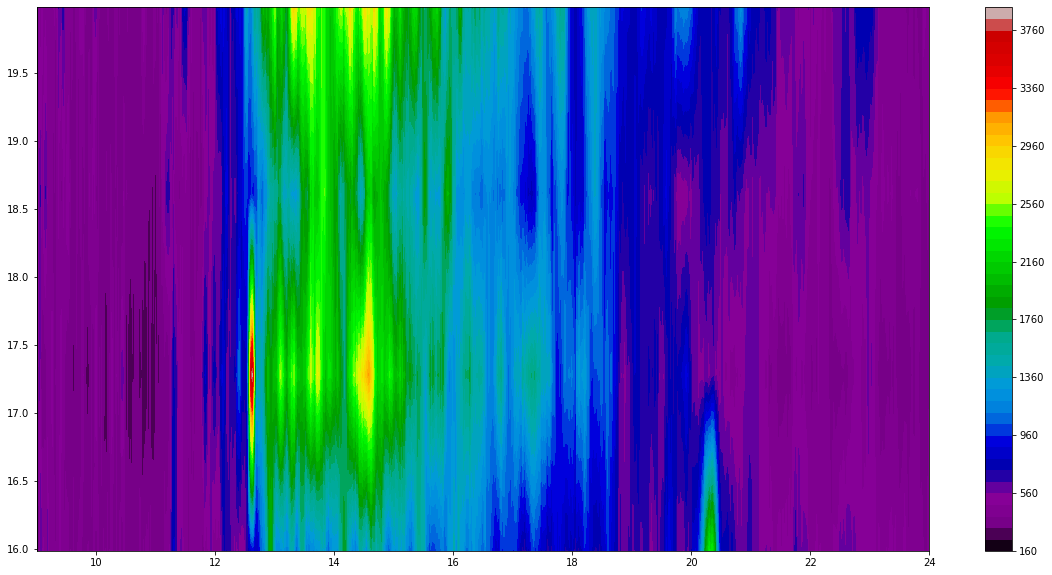

In [23]:
df = saph.scan_data[saph.scan_data['rotation']==72]
x, y, Z = saph.return_scan_data('intensity',df)
fig, ax = plt.subplots(figsize = (20,10))
vmin = 200
Z[Z<vmin]=vmin
cma = ax.contourf(y,x,Z, levels=50, cmap='nipy_spectral')
cba = plt.colorbar(cma, ax=ax)
plt.xlim(9,24)

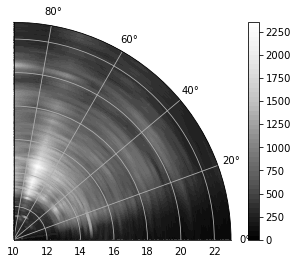

In [24]:
x, y, Z = saph.return_scan_data('rotation')
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
r,theta = np.meshgrid(y,np.radians(x))
l4 =1100
pa = ax.contourf(theta, r, Z, levels=50, cmap='Greys_r')
ax.set_thetalim(np.radians(min(x)), np.radians(max(x)))
ax.set_rlim(10,23)
cba = plt.colorbar(pa, ax=ax)



So this is the easiest way to do stuff. What is does is it groups the data frame by the specific stage you specify and then it returns the mean of each group. Then it finds the lineout.  But as we have it all in dataframe it is easy to pick specific groups for example at the bottom I repeat the roation plots for different internsities.

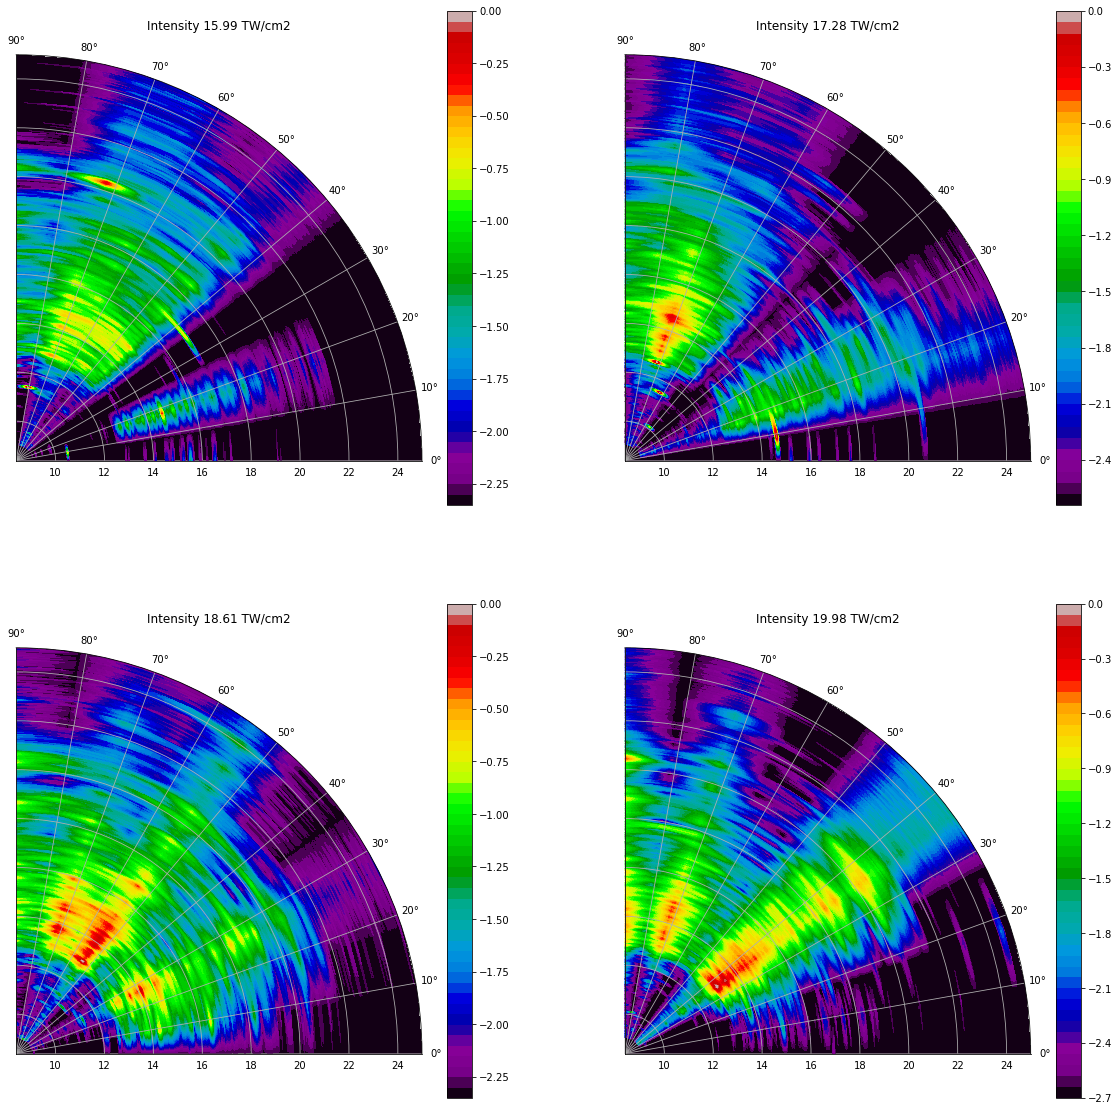

In [25]:
img = Image()
irises= np.unique(saph.scan_data.iris)
inten = [iris.get_intensity_TWcm2(i) for i in irises]
fig, ax = plt.subplots(2,2,subplot_kw={'projection': 'polar'}, figsize=(20,20))
ax = ax.flatten()
for i in range(len(irises)):
    df = saph.scan_data[saph.scan_data['iris']==irises[i]]
    x,y,Z = saph.return_scan_data('rotation', df = df)
    r,theta = np.meshgrid(y,np.radians(x))
    vmin = 300
    Z[Z<vmin]=vmin
    Z = Z/max(Z.flatten())
    pa = ax[i].contourf(theta, r, np.log(Z), levels=50, cmap='nipy_spectral')
    ax[i].set_thetalim(np.radians(min(x)), np.radians(max(x)))
    ax[i].set_title('Intensity {} TW/cm2'.format(np.round(inten[i],2)))
    cba = plt.colorbar(pa, ax=ax[i])
